This Python code translates the R code (the example_acm.R)  The code creates a scatter plot that displays an adaptive comfort model based on the ASHRAE Global Thermal Comfort Database II. The plot shows the relationship between outdoor temperature and neutral temperature for different building cooling types: Air Conditioned, Mixed Mode, and Naturally Ventilated. </br>

In [59]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from matplotlib.ticker import FormatStrFormatter


In [50]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


To conduct adaptive thermal model analysis, we need concurrent observations of indoor air temperature, thermal sensation vote, and outdoor mean monthly temperature. However, here here the orignial R code (Python version) also requires relative humidity data.

In [56]:
# remove nan values in Ta, thermal_sensation, and t_out_isd or t_out
df_acm = df_measurements.loc[(~df_measurements['ta'].isna()) &
                              (~df_measurements['thermal_sensation'].isna()) &
                              (~df_measurements['rh'].isna()) &
                              (~(df_measurements['t_out_isd'].isna()) | ~(df_measurements['t_out'].isna()))].copy()
print('number of buildings that have required data for acm:', len(df_acm.building_id.unique()))

# Fill the missing values in the outdoor temperature column
df_acm.loc[:, 't_out_combined'] = df_acm.loc[:, 't_out_isd'].fillna(df_acm.loc[:, 't_out'])

# Remove original temperature columns
df_acm = df_acm.drop(columns=['t_out_isd', 't_out'])

# Merge metadata and databased by office buildings
df_acm = df_acm.merge(df_meta[['building_id', 'region', 'building_type', 'cooling_type', 'records']], on='building_id', how='left')
df_acm = df_acm[df_acm['building_type'] == 'office']
df_acm = df_acm.drop(columns=['building_type'])
print('number of office buildings that have required data for acm:', len(df_acm.building_id.unique()))


number of buildings that have required data for acm: 732
number of office buildings that have required data for acm: 304


The orginal R code evalue the p-value of intercept

In [57]:
# Calculate the neutral temperature for each building
def run_lm(bldg):
    try:
        lm_result = smf.ols(formula='ta ~ thermal_sensation', data=bldg).fit()
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            return lm_result.params['Intercept']
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

df_models = df_acm.groupby('building_id').apply(run_lm).reset_index()
df_models.columns = ['building_id', 'neutral_temp']
df_models = df_models.merge(df_meta[['building_id', 'records', 'cooling_type', 'region']], on='building_id', how='left')
df_models['t_out_mean'] = df_acm.groupby('building_id')['t_out_combined'].mean().values
# get rid of all nan values in the neutral_temp column
df_models = df_models[~df_models['neutral_temp'].isna()]
df_models


,building_id,neutral_temp,records,cooling_type,region,t_out_mean
0,1,22.585738,170,mixed mode,oceania,15.296857
1,2,22.058339,83,air conditioned,oceania,13.995833
2,3,23.142187,85,air conditioned,americas,0.583480
3,4,23.642083,137,mixed mode,oceania,19.284220
4,5,22.071788,128,air conditioned,americas,9.048210
...,...,...,...,...,...,...
299,763,20.837842,134,naturally ventilated,europe,9.983256
300,771,23.439683,161,air conditioned,europe,15.119837
301,772,23.082808,94,air conditioned,europe,2.571260
302,779,28.210619,118,air conditioned,asia,28.855652


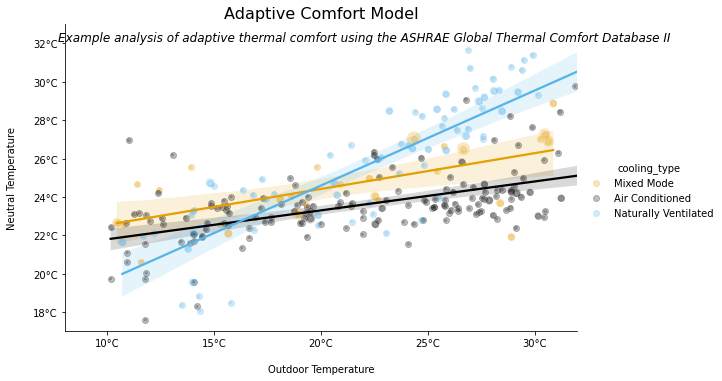

In [60]:
# Visualization
# Assuming df_models is already loaded
filtered_df = df_models[(df_models['t_out_mean'] >= 10) & (df_models['t_out_mean'] <= 33) &
                        (df_models['neutral_temp'] > 17) & (df_models['neutral_temp'] < 32)].copy()

filtered_df['cooling_type'] = filtered_df['cooling_type'].str.title()
filtered_df['point_size'] = filtered_df['records']

colors = {"Air Conditioned": "#000000", "Mixed Mode": "#E69F00", "Naturally Ventilated": "#56B4E9"}

lm = sns.lmplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                palette=colors, scatter_kws={'alpha': 0.25}, 
                height=5, aspect=1.6)

# Add point_size directly to the scatterplot
sns.scatterplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                size='point_size', sizes=(10, 200), legend=False, 
                palette=colors, alpha=0.25, ax=lm.ax)

lm.ax.set_xlim(8, 32)
lm.ax.set_ylim(17, 33)
lm.ax.set_xlabel('\nOutdoor Temperature')
lm.ax.set_ylabel('Neutral Temperature\n')
lm.ax.xaxis.set_major_formatter(FormatStrFormatter('%d°C'))
lm.ax.yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

# Annotations
lm.ax.annotate("Lower 80%", xy=(33.7, 24.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Lower 90%", xy=(33.7, 25.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 90%", xy=(33.7, 28.0), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 80%", xy=(33.7, 30.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')


plt.title('Adaptive Comfort Model', fontsize=16)
plt.suptitle('Example analysis of adaptive thermal comfort using the ASHRAE Global Thermal Comfort Database II', fontsize=12, fontstyle='italic', y=0.95)
plt.show()

In [63]:
df_models

,building_id,neutral_temp,records,cooling_type,region,t_out_mean
0,1,22.585738,170,mixed mode,oceania,15.296857
1,2,22.058339,83,air conditioned,oceania,13.995833
2,3,23.142187,85,air conditioned,americas,0.583480
3,4,23.642083,137,mixed mode,oceania,19.284220
4,5,22.071788,128,air conditioned,americas,9.048210
...,...,...,...,...,...,...
299,763,20.837842,134,naturally ventilated,europe,9.983256
300,771,23.439683,161,air conditioned,europe,15.119837
301,772,23.082808,94,air conditioned,europe,2.571260
302,779,28.210619,118,air conditioned,asia,28.855652


In [66]:
# Filter the data for naturally ventilated buildings
naturally_ventilated = df_models[df_models['cooling_type'] == 'naturally ventilated']

# Run linear regression between neutral_temp and t_out_mean
lm_result = smf.ols(formula='neutral_temp ~ t_out_mean', data=naturally_ventilated).fit()

# Print the summary of the linear regression
print(lm_result.summary())


                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     141.7
Date:                Tue, 02 May 2023   Prob (F-statistic):           8.54e-20
Time:                        22:14:35   Log-Likelihood:                -204.03
No. Observations:                  87   AIC:                             412.1
Df Residuals:                      85   BIC:                             417.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8851      0.820     19.380      0.0

In [69]:
# display all rows of naturally_ventilated dataframe
pd.set_option('display.max_rows', None)
naturally_ventilated

,building_id,neutral_temp,records,cooling_type,region,t_out_mean
59,61,27.561431,157,naturally ventilated,oceania,26.871975
60,62,27.708039,124,naturally ventilated,oceania,25.653252
61,63,28.116242,69,naturally ventilated,oceania,25.782609
62,64,27.499753,211,naturally ventilated,oceania,26.355213
63,65,26.104500,49,naturally ventilated,oceania,22.820408
83,85,22.518750,126,naturally ventilated,oceania,19.884400
84,86,23.045978,411,naturally ventilated,oceania,19.860097
85,87,22.707339,16,naturally ventilated,oceania,21.450000
133,135,28.988036,583,naturally ventilated,asia,27.378216
135,137,29.555276,193,naturally ventilated,asia,28.342948
